In [2]:
# !pip3 install two-sample-binomial
# !pip3 install multiple-hypothesis-testing

from twosample import binom_test
from multitest import MultiTest

import numpy as np
import scipy


import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize'] =  [8, 6]
mpl.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm

from scipy.stats import poisson, binom, norm, hypergeom, uniform

import pandas as pd

from sample_survival_data import *

In [3]:
#!pip3 install --upgrade multiple-hypothesis-testing

## Findings: (4/8/2022):
 - With $T=100$ and non stable HC, we get ~ 10 new discoveries with HC for genes in the range 100-200
 - About 3 of which relies on 2 P-values (the rest on one) (sparsity, 0.01 - 0.02)
 - To do: 1) try the entire range 2) try larger Ts

## Duscussion:
 - Simulate null of HC and log-rank: shuffle responses vector of each gene -- done
 - Biological intepertation
 - Try merging time stamps -- works


## Data:
- Min HypGeom 
- Look for data.
    - SCANB ~ 3000 patients ~1000 unique time points
    - Keywords: dose response curve,
    - Perhaps survival of flies
- 

In [4]:
from survival import ( hypergeom_test, q95)

def log_rank_test(Nt1, Nt2, Ot1, Ot2, alternative='two-sided'):
    """
    log-rank test 
    We assume that len(Nt1) == len(Nt2), and that each
    entry in either list represents an event in which
    a change occurs in the number of items in each groups 
    (the change in each group may also be zero)
    
    Args:
    -----
    :Nt1:   vector of counts in group 1 (each count corresponds to an event)
    :Nt2:   vector of counts in group 2 
    :alternative:   options are: 'greater', 'less', or 'two-sided'
                    with 'greater', test against the alternative that
                    more events occured in Nt2 compared to Nt1
    Returns:
    -------
    :z:       z score of the log-rank test
    :pvalue:  P-value
    """

    assert (len(Nt1) == len(Nt2))
    assert (len(Ot1) == len(Ot2))
    assert (len(Ot1) == len(Nt1))
    
    Nt = Nt2 + Nt1
    e0 = Nt2 * (Ot1 + Ot2) / Nt
    var0 = e0 * ((Nt - (Ot1 + Ot2)) / Nt) * (Nt1 / (Nt - 1))

    z = np.sum(Ot2 - e0) / np.sqrt(np.sum(var0))

    if alternative == 'greater':
        pval = norm.sf(z)
    elif alternative == 'less':
        pval = norm.cdf(z)
    else:
        pval = 2 * norm.cdf(-np.abs(z))

    return z, pval


In [5]:
def multi_pvals(Nt1, Nt2, Ot1, Ot2, test='hypergeom',
                randomize=False, alternative='greater'):
    """
    Compute P-values from the pair list of coutns in the two groups.
    We have one p-value per event time.
    An even is a pair (Nt1[i], Nt2[i]).
    
    Args:
    -----
    :Nt1:   vector of counts in group 1 (each count corresponds to an event)
    :Nt2:   vector of counts in group 2
    :test:  is the type of test to apply (options are: 'hypergeom' or
     'binomial')
    :randomize:  randomized individual tests or not
    :alternative:   type of alternative to use in each test 

    Return:
        P-values 
    """

    assert (len(Nt1) == len(Nt2))
    assert (len(Ot1) == len(Ot2))
    assert (len(Ot1) == len(Nt1))

    Nt = Nt2 + Nt1

    if test == 'binomial':
        n = Ot1 + Ot2
        p = Nt2 / Nt
        x = Ot2
        pvals = binom_test(x, n, p, randomize=randomize, alt=alternative)
    elif test == 'hypergeom':
        pvals = hypergeom_test(Ot2, Nt, Nt2, Ot1 + Ot2,
                               randomize=randomize, alternative=alternative)

    return pvals


In [6]:

def evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, stbl=True, gamma=.4, randomize=False):
    """
    Args:
    :Nt1: first list of events
    :Nt2: second list of events
    
    Compute several statistics of the two-sample data:
    log-rank
    higher criticism
    Fisher combination test
    minimum P-value
    Berk-Jones
    FDR
    """
    
    lr, lr_pval = log_rank_test(Nt1, Nt2, Ot1, Ot2)
    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=randomize)
    mt = MultiTest(pvals[pvals < 1], stbl=stbl) # if not using stbl=False, then sometimes
                                      # HC misses the significance of the strongest effect 
    
    return {'Logrank': np.abs(lr),
            'HC': mt.hc(gamma=gamma)[0],
            'Fisher': mt.fisher(),
            'minP': mt.minp(),
            'BJ': mt.berk_jones(gamma=.45),
            #'FDR': mt.fdr()[0],
            #'wilcoxon': -np.log(1e-20 + scipy.stats.ranksums(Nt1, Nt2).pvalue),
           }

## Load Data:

In [7]:
#df = pd.read_csv("./Data/Gene_expression_data/AML_Bull.csv")
df = pd.read_csv("./Data/data.csv")
gene_names = [c for c in df.columns if c not in ['Unnamed: 0', 'time', 'event']]

In [136]:
def arrange_group(dfg):
    """
    Group events in time; Find group size in each 
    time sample
    """
    
    dft = dfg#.groupby('time').sum()
    dft = dft.sort_values('time').reset_index()
    dft['total'] = len(dft)
    dft['dead'] = dft.event
    dft['cum_dead'] = dft.dead.cumsum()
    
    # dft['censored'] = (~dft.event).cumsum()
    # incorporate censorship. Change to 'at-risk'
    dft['cum_censored'] = (dft.event == 0).cumsum()
    dft['at-risk'] = dft['total']
    dft.loc[1:,'at-risk'] = dft[1:]['at-risk'].values - dft[:-1]['cum_dead'].values - dft[:-1]['cum_censored'].values
    dft = dft.groupby('time').max()
    assert(np.all(-np.diff(dft['at-risk']) >= dft['dead'].values[:-1]))
    return dft

def two_groups_gene(data, gene_name):
    """
    Arranges relevant data in a two groups format
    for survival analysis based on the examined gene
    
    Args:
    :data:   is a dataframe with :gene_name: as one of its columns.
             additional columns are :time: and :event:
             
    Return:
        dataframe indexed by time and number of survived elements in
        each group
    
    """
    
    dfg = data[[gene_name,'time', 'event']]
    idc_split = dfg[gene_name] >= 1    
    df1 = arrange_group(dfg[idc_split])
    df2 = arrange_group(dfg[~idc_split])
    
    # Todo: merge time indices
    dfm = df1[['at-risk', 'dead']].join(df2[['at-risk', 'dead']], lsuffix='1', rsuffix='2', how='outer')\
                     .fillna(method='ffill')\
                     .fillna(method='bfill') 
    return dfm

In [137]:
EPS = 1e-20

def evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, **kwargs):
    """
    Evaluate many tests for comparing the lists Nt1 and Nt2

    Args:
    :Nt1: first list of at-risk subjects
    :Nt2: second list of at-risk subjects
    :Ot1: number of events in group 1
    :Ot2: number of events in group 2


    Compute several statistics of the two-sample data:
    log-rank
    higher criticism
    Fisher combination test
    minimum P-value
    Berk-Jones
    Wilcoxon ranksum
    """

    randomize = kwargs.get('randomize', False)
    alternative = kwargs.get('alternative', 'both')  # 'both' != 'two-sided'
    stbl = kwargs.get('stbl', True)

    test_results = {}

    #test_results['log_rank_lifeline'] = -np.log(lrln_pval + EPS)

    if alternative == 'both' or alternative == 'greater':
        lr, lr_pval = log_rank_test(Nt1, Nt2, Ot1, Ot2, alternative='greater')
        test_results['log_rank_greater'] = np.abs(lr)  # large values are significant

        pvals_greater = multi_pvals(Nt1, Nt2, Ot1, Ot2, alternative='greater',
                                    randomize=randomize)
        mt = MultiTest(pvals_greater[pvals_greater<1], stbl=stbl)
        # if not using stbl=False, then sometimes
        # HC misses the significance of the strongest effect
        test_results['hc_greater'] = mt.hc()[0]
        test_results['fisher_greater'] = mt.fisher()
        test_results['min_p_greater'] = mt.minp()
        test_results['berk_jones_greater'] = mt.berk_jones(gamma=.45)
        test_results['wilcoxon_greater'] = -np.log(scipy.stats.ranksums(
            Nt1, Nt2, alternative='greater').pvalue + EPS)

    if alternative == 'both' or alternative == 'less':
        lr, lr_pval = log_rank_test(Nt1, Nt2, Ot1, Ot2, alternative='less')
        test_results['log_rank_less'] = np.abs(lr)  # large values are significant

        pvals_less = multi_pvals(Nt1, Nt2, Ot1, Ot2, alternative='less',
                                    randomize=randomize)
        mt = MultiTest(pvals_less[pvals_less<1], stbl=stbl)
        # if not using stbl=False, then sometimes
        # HC misses the significance of the strongest effect
        test_results['hc_less'] = mt.hc()[0]
        test_results['fisher_less'] = mt.fisher()
        test_results['min_p_less'] = mt.minp()
        test_results['berk_jones_less'] = mt.berk_jones(gamma=.45)
        test_results['wilcoxon_less'] = -np.log(scipy.stats.ranksums(
            Nt1, Nt2, alternative='less').pvalue + EPS)

    if alternative == 'two-sided':
        lr, lr_pval = log_rank_test(Nt1, Nt2, Ot1, Ot2, alternative='two-sided')
        test_results['log_rank'] = np.abs(lr)

        pvals_2sided = mutli_pvals(Nt1, Nt2, Ot1, Ot2, alternative='two-sided',
                                    randomize=randomize)
        mt = MultiTest(pvals_2sided[pvals_2sided<1], stbl=stbl)
        # if not using stbl=False, then sometimes
        # HC misses the significance of the strongest effect
        test_results['hc'] = mt.hc()[0]
        test_results['fisher'] = mt.fisher()
        test_results['min_p'] = mt.minp()
        test_results['berk_jones'] = mt.berk_jones(gamma=.45)
        test_results['wilcoxon'] = -np.log(scipy.stats.ranksums(
            Nt1, Nt2, alternative='two-sided').pvalue + EPS)

    return test_results


In [138]:
def reduce_time_resolution(df, T):
    """
    Group together events in surivial data
    across uniform time intervals. 
    
    Args:
    :df: original dataset. Index represent time of events
    :T:  maximal number of time intervals
    
    """
    
    Tmin = df.index.min()
    Tmax = df.index.max()
    tt = np.linspace(Tmin, Tmax, T)
    dfc = pd.DataFrame()
    for t_down, t_up in zip(tt[:-1], tt[1:]):
        dft = df[(t_down <= df.index) & (df.index < t_up)]
        r = dft.sum()[['dead1', 'dead2']]
        r['at-risk1'] = dft['at-risk1'].max()
        r['at-risk2'] = dft['at-risk2'].max()
        dfc = dfc.append(r, ignore_index=True)
    return dfc.fillna(method='backfill').dropna()

In [139]:
def test_gene(data, gene_name, T, stbl=False):
    """
    Evaluate all test statistics for comparing the survival curves
    for the two groups involving the response of :gene_name: 
    Also, consolidate event times based on :T:. 
    
    Args:
    :data: is the entire dataset containing the group division 
            at minimum, :data: should contain the columns  
            :gene_name:, `events`, `time`
    :gene_name:  the name of the column to test
    :T:    is the new maximal time interval. If T == -1 then we 
            use the original times
    
    """
    if T > 0:
        dfr = reduce_time_resolution(two_groups_gene(data, gene_name), T)
    else:
        dfr = two_groups_gene(df, gene_name)
    r = evaluate_test_stats(dfr['at-risk1'].values, dfr['at-risk2'].values,
                            dfr['dead1'].values, dfr['dead2'].values,
                            stbl=stbl, randomize=False
                           )
    rrev = evaluate_test_stats(dfr['at-risk2'].values, dfr['at-risk1'].values,
                               dfr['dead2'].values, dfr['dead1'].values,
                              stbl=stbl, randomize=False)

    r['name'] = gene_name 
    rrev['name'] = gene_name

    lam1 = 1 / np.sum(1 / dfr['dead1'])
    lam2 = np.log(dfr['at-risk2'].max() / dfr['at-risk2'].min()) / T
    r['x0'] = dfr['at-risk1'].max()
    r['y0'] = dfr['at-risk2'].max()
    r['lam1'] = lam1
    r['lam2'] = lam2
    
    rdf = pd.DataFrame(r, index=[0])
    revdf = pd.DataFrame(rrev, index=[0])
    
    
    return rdf.join(revdf, rsuffix='_rev')

In [182]:
np.mean(dfr['dead2'])

2.4646464646464645

In [185]:
dfr['at-risk2']

0     1535.0
1     1535.0
2     1533.0
3     1533.0
4     1530.0
       ...  
94      74.0
95      61.0
96      36.0
97      21.0
98      10.0
Name: at-risk2, Length: 99, dtype: float64

In [140]:
def simulate_null(T, N1, N2, lam0, nMonte, stbl=True):
    """
    Args:
    -----
    :N1:      Initial size of group 1
    :N2:      Initial size of group 2
    :T:       Total numebr of events
    :nMonte:  number of experiments to evaluate

    """
    
    df0 = pd.DataFrame()
    print("Simulating null...")
    for itr in tqdm(range(nMonte)):
        Nt1, Nt2 = sample_survival_data(T, N1, N2, lam0 * np.ones(T), 0, 0)
        Ot1 = -np.diff(Nt1)
        Ot2 = -np.diff(Nt2)
        res = evaluate_test_stats(Nt1[:-1], Nt2[:-1], Ot1, Ot2, stbl=True)
        df0 = df0.append(res, ignore_index=True)

    # critical values under the null:
    return df0


def std_95(x):
    return np.std(x) / np.sqrt(len(x)) * np.sqrt(.95 * (1 - .95) )

def simulate_null_data(data, T, rep = 1, stbl=True):
    """
    Generate random group assignments. 
    Evaluate test statistics. 

    """
    
    df0 = pd.DataFrame()
    gene_names = [c for c in df.columns if c not in ['Unnamed: 0', 'time', 'event']]
    
    print("Simulating null using data...")
    
    for _ in range(rep):
        print("Sampling a random division...")
        df_copy = df.copy()
        df_copy.iloc[:, 1:-2] = np.random.randint(2, size = df.iloc[:, 1:-2].shape)
        print(f"Testing {len(gene_names)} 'null' genes...")
        for gene_name in tqdm(gene_names): 
            res = test_gene(df_copy, gene_name, T, stbl=stbl)
            df0 = df0.append(res, ignore_index=True)

    # critical values under the null:
    return df0


In [174]:
np.seterr(all='warn')

T = 1000
res = pd.DataFrame()
stbl = False

df0_data = simulate_null_data(df, T, rep=1, stbl=False)
df0_data.to_csv(f'null_data_stbl_{stbl}_T{T}.csv')
df0_data.agg([q95,'std'])

Simulating null using data...
Sampling a random division...


  0%|          | 0/9259 [00:00<?, ?it/s]

Testing 9259 'null' genes...


  2%|▏         | 151/9259 [05:21<5:23:20,  2.13s/it]


KeyboardInterrupt: 

In [144]:
df0_data = pd.read_csv(f'null_data_stbl_{stbl}_T{T}.csv')
df0_data.agg([q95])

In [173]:
df0_mean = df0_data.agg(['mean'])
df0_q = df0_data.agg([q95])
df0_std = df0_data.agg(['std'])
n = len(df0_data)

print(f"T * lam = {T * df0_mean['lam1'].values} ({T * df0_std['lam1'].values/np.sqrt(n)})")
print(f"x0 = {df0_mean['x0'].values} ({df0_std['x0'].values/np.sqrt(n)})")
print(f"y0 = {df0_mean['y0'].values} ({df0_std['y0'].values/np.sqrt(n)})")
print(f"HC = {df0_q['hc_greater'].values} ({df0_std['hc_greater'].values/np.sqrt(n)})")
print(f"LR = {df0_q['log_rank_greater'].values} ({df0_std['log_rank_greater'].values / np.sqrt(n)})")

T * lam = [5.2209528] ([0.00251044])
x0 = [1534.39561508] ([0.28649218])
y0 = [1534.60438492] ([0.28649218])
HC = [1.20810864] ([0.01174395])
LR = [1.79965348] ([0.00570007])


In [169]:
df0_mean

,Unnamed: 0,log_rank_greater,hc_greater,fisher_greater,min_p_greater,berk_jones_greater,wilcoxon_greater,log_rank_less,hc_less,fisher_less,...,fisher_greater_rev,min_p_greater_rev,berk_jones_greater_rev,wilcoxon_greater_rev,log_rank_less_rev,hc_less_rev,fisher_less_rev,min_p_less_rev,berk_jones_less_rev,wilcoxon_less_rev
mean,4629.0,0.728991,-0.763444,1.267068,3.469714,17.256014,1.197384,0.728991,196.425985,23.831181,...,1.268615,3.486447,17.273302,1.212397,0.728991,196.393012,23.841865,46.051702,46.051702,1.197384


In [147]:
0.548 / np.sqrt(len(df0_data))

0.005695062786723607

In [18]:
df0_data = pd.read_csv("null_data_stbl.csv")
df0_data.agg([q95])

,Unnamed: 0,log_rank_greater,hc_greater,fisher_greater,min_p_greater,berk_jones_greater,wilcoxon_greater,log_rank_less,hc_less,fisher_less,...,min_p_greater_rev,berk_jones_greater_rev,wilcoxon_greater_rev,log_rank_less_rev,hc_less_rev,fisher_less_rev,min_p_less_rev,berk_jones_less_rev,wilcoxon_less_rev,name_rev
q95,8795.1,1.790985,0.720442,1.527604,5.309598,25.50439,3.505153,1.790985,4.975899,27.763616,...,5.378988,25.279923,3.494196,1.790985,4.975899,27.767019,46.051702,46.051702,3.505153,NaN


In [149]:
df0_data.agg([q95])['lam1'] * df0_data.agg([q95])['x0']

q95    90.141867
dtype: float64

In [153]:
df0_data.agg([q95])['lam2'] * df0_data.agg([q95])['y0']

q95    89.950324
dtype: float64

In [59]:
# here we go over all genes:

res = pd.DataFrame()
for gene_name in tqdm(gene_names[:100]):
   # try:
    r = test_gene(df, gene_name, T)
    res = res.append(r, ignore_index=True)
   # except:
        #print(f"Error in evaluating {gene_name}")
res

100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


,log_rank_greater,hc_greater,fisher_greater,min_p_greater,berk_jones_greater,wilcoxon_greater,log_rank_less,hc_less,fisher_less,min_p_less,...,min_p_greater_rev,berk_jones_greater_rev,wilcoxon_greater_rev,log_rank_less_rev,hc_less_rev,fisher_less_rev,min_p_less_rev,berk_jones_less_rev,wilcoxon_less_rev,name_rev
0,1.070805,-1.086000,1.329342,3.244009,12.834642,9.535957e-01,1.070805,187.220085,19.436281,46.051702,...,1.973399,21.404728,0.486707,1.070805,197.06843,26.133906,46.051702,46.051702,9.535957e-01,A2M
1,5.755372,-2.408862,0.808138,2.245322,46.051702,1.834232e-09,5.755372,197.068430,22.786108,46.051702,...,7.093767,5.482041,20.116640,5.755372,197.06843,29.653493,46.051702,46.051702,1.834232e-09,A4GNT
2,0.132393,0.933975,1.347118,4.914391,18.102450,1.115884e+00,0.132393,197.068430,25.729030,46.051702,...,3.398155,16.769162,0.396940,0.132393,197.06843,24.010613,46.051702,46.051702,1.115884e+00,AAAS
3,0.066357,1.116255,1.351100,5.406795,15.646347,6.225729e-01,0.066357,197.068430,24.061792,46.051702,...,2.821480,16.387190,0.769083,0.066357,197.06843,24.946046,46.051702,46.051702,6.225729e-01,AACS
4,1.472876,-0.458386,1.383393,3.944332,12.831149,5.874777e-01,1.472876,197.068430,20.286491,46.051702,...,2.289788,23.828502,0.811317,1.472876,197.06843,26.085051,46.051702,46.051702,5.874777e-01,AADAC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.117181,-0.199705,1.326484,4.132959,15.949316,6.070993e-01,0.117181,197.068430,24.949424,46.051702,...,3.528897,16.587511,0.787302,0.117181,197.06843,24.924252,46.051702,46.051702,6.070993e-01,ACSBG1
96,0.234478,-0.345255,1.446071,3.794712,8.526997,8.437300e-01,0.234478,197.068430,27.701347,46.051702,...,2.444361,10.643684,0.562300,0.234478,197.06843,22.392596,46.051702,46.051702,8.437300e-01,ACSBG2
97,0.596696,-0.582866,1.060957,3.465739,26.224309,2.736755e-01,0.596696,197.068430,22.574973,46.051702,...,2.747890,13.307449,1.429531,0.596696,197.06843,22.125992,46.051702,46.051702,2.736755e-01,ACSL1
98,0.021684,-1.002829,1.261917,2.774381,13.599092,4.043157e-01,0.021684,197.068430,24.977833,46.051702,...,2.951674,12.722628,1.100915,0.021684,197.06843,23.154701,46.051702,46.051702,4.043157e-01,ACSL3


In [ ]:
T = 100
res = pd.DataFrame()
stbl = True

for gene_name in tqdm(gene_names):
    dfr = reduce_time_resolution(two_groups_gene(df, gene_name), T)
    r = evaluate_test_stats(dfr['at-risk1'].values, dfr['at-risk2'].values,
                            dfr['dead1'].values, dfr['dead2'].values,
                            stbl=stbl, randomize=False
                           )
    rrev = evaluate_test_stats(dfr['at-risk2'].values, dfr['at-risk1'].values,
                               dfr['dead2'].values, dfr['dead1'].values,
                              stbl=stbl, randomize=False)

    r['name'] = gene_name 
    rrev['name'] = gene_name

    rdf = pd.DataFrame(r, index=[0])
    revdf = pd.DataFrame(rrev, index=[0])
    
    res = res.append(rdf.join(revdf, rsuffix='_rev'), ignore_index=True)


In [119]:
def arrange_group(dfg):
    """
    Group events in time; Find group size in each 
    time sample
    """
    
    dft = dfg.sort_values('time').reset_index()
    dft['total'] = len(dft)
    dft['dead'] = dft.event
    dft['cum_dead'] = dft.dead.cumsum()
    
    # dft['censored'] = (~dft.event).cumsum()
    # incorporate censorship. Change to 'at-risk'
    dft['cum_censored'] = (dft.event == 0).cumsum()
    dft['at-risk'] = dft['total']
    dft.loc[1:,'at-risk'] = dft[1:]['at-risk'].values - dft[:-1]['cum_dead'].values - dft[:-1]['cum_censored'].values
    
    dft = dft.groupby('time').max()
    return dft


In [116]:
dft.loc[1:,'at-risk'] = 
dft

In [135]:
dft = dfg.sort_values('time').reset_index()
dft['total'] = len(dft)
dft['dead'] = dft.event
dft['cum_dead'] = dft.dead.cumsum()

# dft['censored'] = (~dft.event).cumsum()
# incorporate censorship. Change to 'at-risk'
dft['cum_censored'] = (dft.event == 0).cumsum()

dft['at-risk'] = dft['total']
dft.loc[1:,'at-risk'] = dft[1:]['at-risk'].values - dft[:-1]['cum_dead'].values - dft[:-1]['cum_censored'].values
dft = dft.groupby('time').max()
assert(np.all(-np.diff(dft['at-risk']) >= dft['dead'].values[:-1]))

array([1., 1., 1., ..., 0., 0., 0.])

In [97]:
gene_name = gene_names[0]
data = df.copy()
dfg = data[[gene_name,'time', 'event']]
idc_split = dfg[gene_name] >= 1    
df1 = arrange_group(dfg[idc_split])
df2 = arrange_group(dfg[~idc_split])

# Todo: merge time indices
dfm = df1[['at-risk', 'dead']].join(df2[['at-risk', 'dead']], lsuffix='1', rsuffix='2', how='outer')\
                 .fillna(method='ffill')\
                 .fillna(method='bfill') 
dfm

,at-risk1,dead1,at-risk2,dead2
time,,,,
56.0,1534.0,1.0,1535.0,1.0
93.0,1534.0,1.0,1535.0,1.0
101.0,1532.0,1.0,1535.0,1.0
136.0,1532.0,1.0,1533.0,1.0
141.0,1532.0,1.0,1532.0,1.0
...,...,...,...,...
2468.0,2.0,0.0,8.0,0.0
2469.0,2.0,0.0,4.0,0.0
2472.0,2.0,0.0,3.0,0.0


In [91]:
dfo = two_groups_gene(df, gene_name)
-np.diff(dfo['at-risk1']) >= dfo['dead1'][:-1]

ValueError: ('Lengths must match to compare', (0,), (1128,))

In [95]:
dfo['dead1']

time
56.0      1.0
93.0      1.0
101.0     1.0
136.0     1.0
141.0     1.0
         ... 
2468.0    0.0
2469.0    0.0
2472.0    0.0
2473.0    0.0
2474.0    0.0
Name: dead1, Length: 1129, dtype: float64

In [96]:
dfo

,at-risk1,dead1,at-risk2,dead2
time,,,,
56.0,1534.0,1.0,1535.0,1.0
93.0,1534.0,1.0,1535.0,1.0
101.0,1532.0,1.0,1535.0,1.0
136.0,1532.0,1.0,1533.0,1.0
141.0,1532.0,1.0,1532.0,1.0
...,...,...,...,...
2468.0,2.0,0.0,8.0,0.0
2469.0,2.0,0.0,4.0,0.0
2472.0,2.0,0.0,3.0,0.0


In [94]:
-np.diff(dfo['at-risk1'])

array([-0.,  2., -0., ..., -0., -0., -0.])

In [389]:
lam0 = .5*(np.log(dfr['at-risk1'].max() / dfr['at-risk1'].min()) / T) + .5*(np.log(dfr['at-risk2'].max() / dfr['at-risk2'].min()) / T)
res0 = simulate_null(T, 1500, 1500, lam0, 1000)
res0

  1%|          | 7/1000 [00:00<00:14, 67.02it/s]

Simulating null...


 63%|██████▎   | 630/1000 [00:06<00:03, 98.60it/s]<ipython-input-346-4025eac20da7>:30: RuntimeWarning: invalid value encountered in true_divide
  e0 = Nt2 * (Ot1 + Ot2) / Nt
<ipython-input-346-4025eac20da7>:31: RuntimeWarning: invalid value encountered in true_divide
  var0 = e0 * ((Nt - (Ot1 + Ot2)) / Nt) * (Nt1 / (Nt - 1))
100%|██████████| 1000/1000 [00:10<00:00, 97.87it/s]


,berk_jones_greater,berk_jones_less,fisher_greater,fisher_less,hc_greater,hc_less,log_rank_greater,log_rank_less,min_p_greater,min_p_less,wilcoxon_greater,wilcoxon_less
q95,13.260447,46.051702,1.923987,20.215973,1.17156,4.969994,1.991719,1.991719,6.571421,46.051702,1.66171,1.686086


In [455]:
df0_data

,log_rank_greater,hc_greater,fisher_greater,min_p_greater,berk_jones_greater,wilcoxon_greater,log_rank_less,hc_less,fisher_less,min_p_less,...,min_p_greater_rev,berk_jones_greater_rev,wilcoxon_greater_rev,log_rank_less_rev,hc_less_rev,fisher_less_rev,min_p_less_rev,berk_jones_less_rev,wilcoxon_less_rev,name_rev
q95,1.785793,1.195944,1.528463,5.343371,25.353016,3.4743,1.785793,197.06843,27.760701,46.051702,...,5.347778,25.523275,3.477099,1.785793,197.06843,27.776471,46.051702,46.051702,3.4743,NaN


In [390]:
res0

,berk_jones_greater,berk_jones_less,fisher_greater,fisher_less,hc_greater,hc_less,log_rank_greater,log_rank_less,min_p_greater,min_p_less,wilcoxon_greater,wilcoxon_less
q95,13.260447,46.051702,1.923987,20.215973,1.17156,4.969994,1.991719,1.991719,6.571421,46.051702,1.66171,1.686086


In [54]:
# filter results
LRt = 2
HCt = 2
HCp = 2
minPt = 12.45

resi = res[((res.hc_greater > HCt) & (res.log_rank_greater < LRt) & 
           (res.hc_greater_rev < HCp) & (res.log_rank_greater_rev < LRt) )
           | 
           ((res.hc_greater < HCp) & (res.log_rank_greater < LRt) & 
           (res.hc_greater_rev > HCt) & (res.log_rank_greater_rev < LRt) )
          ]
resi

AttributeError: 'DataFrame' object has no attribute 'hc_greater'

In [478]:
remote_dir = "/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/Figs/"

In [563]:
def empirical_pval(x, stat_name, df0):
    return np.mean(df0[stat_name].values >= x)

In [738]:
def find_changes(Nt1, Nt2, Ot1, Ot2, stbl=False, gamma=.5):
    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
    mt = MultiTest(pvals[pvals<=1], stbl=stbl) 
    hc, hct = mt.hc(gamma=gamma)
    return pvals <= hct


def illustrate_survival_curves(df, gene_name, T):
    dfg = reduce_time_resolution(two_groups_gene(df, gene_name), T)

        
    Nt1, Nt2 = dfg['at-risk1'].values, dfg['at-risk2'].values
    Ot1, Ot2 = dfg['dead1'].values, dfg['dead2'].values
    
    stats = evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, stbl=stbl, randomize=False)
    
    if stats['hc_greater'] < HCt: # reverse groups
        print("reversing...")
        dfg = dfg.rename(columns={'at-risk1': 'at-risk2', 'at-risk2': 'at-risk1', 
                         'dead1': 'dead2', 'dead2': 'dead1'})
        
        Nt1, Nt2 = dfg['at-risk1'].values, dfg['at-risk2'].values
        Ot1, Ot2 = dfg['dead1'].values, dfg['dead2'].values
        stats = evaluate_test_stats(Nt1, Nt2, Ot1, Ot2,
                                    stbl=stbl, randomize=False)
    
    
    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
    mt = MultiTest(pvals[pvals<1], stbl=stbl) # if not using stbl=False, then sometimes
    hc, hct = mt.hc(gamma=.5)
    print("HC = ", hc)
    fpval = find_changes(Nt1, Nt2, Ot1, Ot2,
                         stbl=stbl)
    
    dfg['pvalue'] = pvals
    dfg['Group 1'] = dfg['at-risk1'] / dfg['at-risk1'].max()
    dfg['Group 2'] = dfg['at-risk2'] / dfg['at-risk2'].max()
    #dfg['censored1'] = dfg['at-risk1'] - dfg['']
    
    plt.step(dfg.index, dfg['Group 1'], 'b')
    plt.step(dfg.index, dfg['Group 2'], 'r')
    
    plt.bar(dfg.index[:len(fpval)], fpval, color='k', alpha=.2)
    hc_pval = empirical_pval(stats['hc_greater'], 'hc_greater', df0_data)
    hc_pval_rev = empirical_pval(stats['hc_greater_rev'], 'hc_greater_rev', df0_data)
    logrank_pval = empirical_pval(stats['log_rank_greater'], 'log_rank_greater', df0_data)
    plt.title(f"{gene_name}, (HC={np.round(hc_pval,2)},  Log-rank={np.round(logrank_pval,2)})")
    plt.ylabel('proportion')
    #plt.savefig(f"Figs/{gene_name}.png")
    #plt.xlim(1000, 1500)
    plt.show()
    
    spv = np.sort(pvals)
    n = len(pvals)
    uu = np.linspace(1/n, 1, n)
    plt.plot(uu, uu, alpha=.3, color='k')
    plt.step(uu, spv, 'b')
    plt.step(uu[spv < hct], spv[spv < hct], 'r')
    plt.title("sorted P-values")
    plt.show()
    
    plt.plot(mt._zz)
    plt.title("z scores of P-values")
    plt.show()

def illustrate_survival_curve(df, gene_name, T):
    dfg = reduce_time_resolution(two_groups_gene(df, gene_name), T)
    
    Nt1, Nt2 = dfg['at-risk1'].values, dfg['at-risk2'].values
    Ot1, Ot2 = dfg['dead1'].values, dfg['dead2'].values
    
    stats = evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, stbl=stbl, randomize=False)
    stats_rev = evaluate_test_stats(Nt2, Nt1, Ot2, Ot1, stbl=stbl, randomize=False)
    
    if stats['hc_greater'] < HCt: # reverse groups
        print("reversing...")
        dfg = dfg.rename(columns={'at-risk1': 'at-risk2', 'at-risk2': 'at-risk1', 
                         'dead1': 'dead2', 'dead2': 'dead1'})
        temp = stats
        stats = stats_rev
        stats_rev = temp
        
        
    print("HC (evaluate_test_stats) = ", stats['hc_greater'])
    
    Nt1, Nt2 = dfg['at-risk1'].values, dfg['at-risk2'].values
    Ot1, Ot2 = dfg['dead1'].values, dfg['dead2'].values
    
    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
    pvals_rev = multi_pvals(Nt2, Nt1, Ot2, Ot1, randomize=False)
    mt = MultiTest(pvals[pvals<1], stbl=stbl) # if not using stbl=False, then sometimes
    hc, hct = mt.hc(gamma=.5)
    print("HC = ", hc)
    fpval = find_changes(Nt1, Nt2, Ot1, Ot2,
                         stbl=stbl)
    
    dfg['pvalue'] = pvals
    dfg['pvalue_rev'] = pvals_rev
    dfg['Survival Proprotion X'] = dfg['at-risk1'] / dfg['at-risk1'].max()
    dfg['Survival Proprotion Y'] = dfg['at-risk2'] / dfg['at-risk2'].max()
    #dfg['censored1'] = dfg['at-risk1'] - dfg['']
        
    
    df_disp = dfg[fpval].rename(columns={'at-risk1' : 'at-risk X', 'at-risk2' : 'at-risk Y',
                                     'dead1' : 'events X', 'dead2' : 'events Y'
                                    })
    
    plt.step(dfg.index, dfg['Survival Proprotion X'], 'b')
    plt.step(dfg.index, dfg['Survival Proprotion Y'], 'r')
    
    
    plt.legend([r'$\hat{S}_x$', r'$\hat{S}_y$'], fontsize=16, loc=1)
    
    plt.bar(dfg.index[:len(fpval)], fpval, color='k', alpha=.2, width=.5)
    hc_pval = empirical_pval(stats['hc_greater'], 'hc_greater', df0_data)
    hc_pval_rev = empirical_pval(stats_rev['hc_greater'], 'hc_greater', df0_data)
    logrank_pval = empirical_pval(stats['log_rank_greater'], 'log_rank_greater', df0_data)
#    print(hc_pval)
    st_HC = r"$\hat{p}(\mathrm{HC})$"
    st_HC_rev = r"$\hat{p}(\tilde{\mathrm{HC}})$"
    st_LR = r"$\hat{p}(\mathrm{LR})$"
    plt.title(rf"{gene_name}: {st_HC}={np.round(hc_pval,2)}, {st_HC_rev}={np.round(hc_pval_rev,2)}, {st_LR}={np.round(logrank_pval,2)}")
    #plt.title(f"{gene_name}, (HC={np.round(stats['hc_greater'],2)}, Log-rank={np.round(stats['log_rank_greater'],2)})")
    plt.ylabel('Survival Proportion', fontsize=16)
    plt.xlabel(r'$t$ (Time)', fontsize=16)
    
    return df_disp, dfg
    

HC (evaluate_test_stats) =  2.2939294834199297
HC =  2.2939294834199297


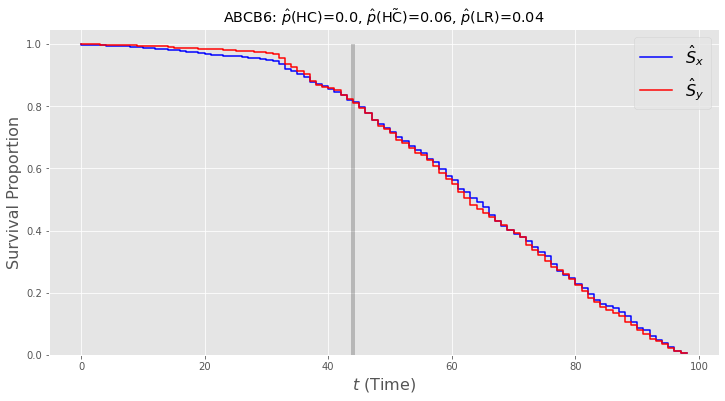

reversing...
HC (evaluate_test_stats) =  2.0280567583209113
HC =  2.0280567583209113


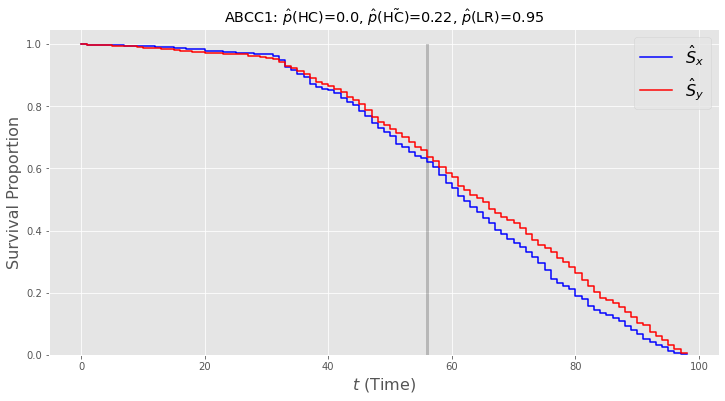

reversing...
HC (evaluate_test_stats) =  4.141537851911224
HC =  4.141537851911224


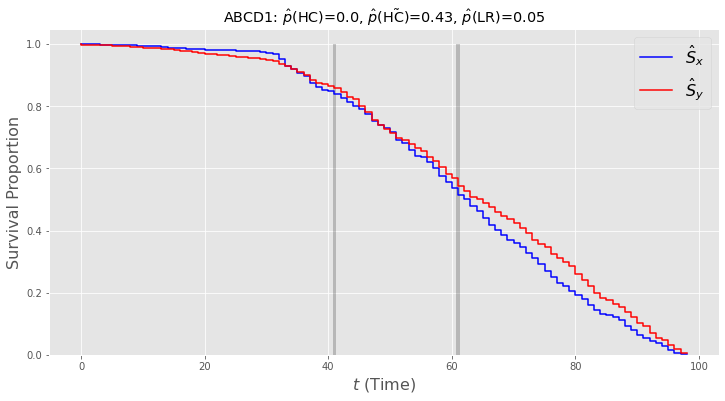

reversing...
HC (evaluate_test_stats) =  2.2864304805030673
HC =  2.2864304805030673


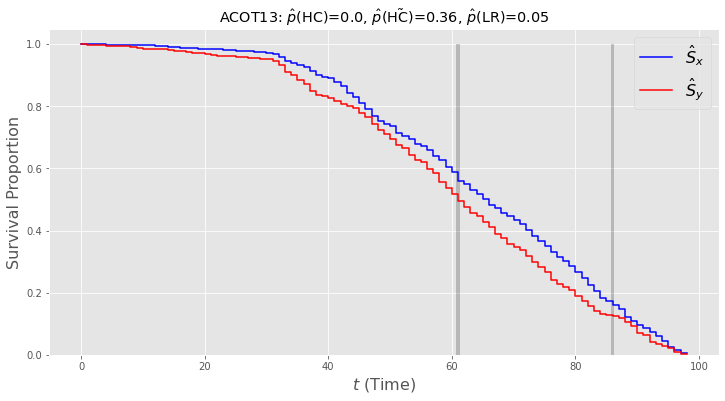

reversing...
HC (evaluate_test_stats) =  3.3546072725676175
HC =  3.3546072725676175


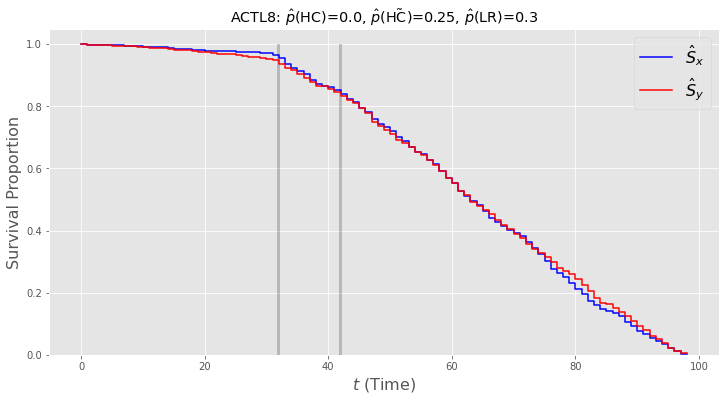

Also report hc_rev pvalue!


In [660]:
plt.rcParams['figure.figsize'] =  [12, 6]

for r in resi.head(5).iterrows():
    gene_name = r[1]['name']
    illustrate_survival_curve(df, gene_name, T)
    plt.show()
    
# HERE!! 
print("Also report hc_rev pvalue!" )

In [661]:
for r in resi.iterrows():
    gene_name = r[1]['name']
    dfg = reduce_time_resolution(two_groups_gene(df, gene_name), T)

        
    Nt1, Nt2 = dfg['at-risk1'].values, dfg['at-risk2'].values
    Ot1, Ot2 = dfg['dead1'].values, dfg['dead2'].values
    
    stats = evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, stbl=stbl, randomize=False)
    
    if stats['hc_greater'] < HCt: # reverse groups
        dfg = dfg.rename(columns={'at-risk1': 'at-risk2', 'at-risk2': 'at-risk1', 
                         'dead1': 'dead2', 'dead2': 'dead1'})
        
        Nt1, Nt2 = dfg['at-risk1'].values, dfg['at-risk2'].values
        Ot1, Ot2 = dfg['dead1'].values, dfg['dead2'].values
        stats = evaluate_test_stats(Nt1, Nt2, Ot1, Ot2,
                                    stbl=stbl, randomize=False)
    
    
    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
    mt = MultiTest(pvals[pvals<1], stbl=stbl) # if not using stbl=False, then sometimes
    hc, hct = mt.hc(gamma=.5)
    fpval = find_changes(Nt1, Nt2, Ot1, Ot2,
                         stbl=stbl)
    if fpval.sum() > 5:
        print(gene_name)

KeyboardInterrupt: 

In [601]:
remote_dir

'/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/Figs/'

## HERE!(9/8/2022)

Why do we have disagreement between 'at-risk1' and 'dead1' (censorship does not explain that)

In [53]:
dfp

NameError: name 'dfp' is not defined

HC (evaluate_test_stats) =  2.614386809105812
HC =  2.614386809105812


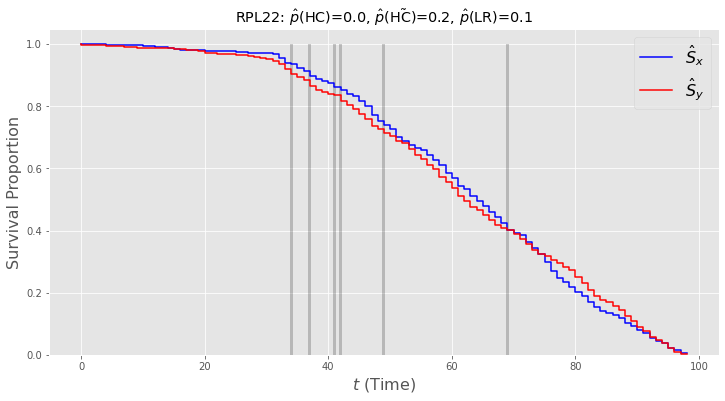

In [739]:
gene_name = 'RPL22'
df_disp, dfp = illustrate_survival_curve(df, gene_name, T)
plt.savefig(remote_dir + gene_name + ".png")
plt.show()

dfd = df_disp.copy()
dfd = dfd.iloc[:, :-2]

for tag in ['pvalue', 'pvalue_rev']:
    dfd[tag] = np.round(dfd[tag],3)

for tag in ['at-risk X', 'at-risk Y', 'events X', 'events Y']:
    dfd[tag] = dfd[tag].astype(int)

dfd.index.name = 'time'
    
rm_dir = "/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/csv/"
dfd.to_csv(rm_dir + f'{gene_name}.csv')


,Unnamed: 0,A2M,A4GNT,AAAS,AACS,AADAC,AAK1,AAMP,AARS,AASDHPPT,...,ZSCAN18,ZSCAN5A,ZW10,ZWINT,ZXDA,ZXDC,ZYX,ZZEF1,time,event


In [229]:
T = 150

df1 = two_groups_gene(df, gene_name)

Tmin = df1.index.min()
Tmax = df1.index.max()
tt = np.linspace(Tmin, Tmax, T)
dfc = pd.DataFrame()
for t_down, t_up in zip(tt[:1], tt[1:2]):
    dft = df1[(t_down <= df1.index) & (df1.index < t_up)]
    r = dft.sum()[['dead1', 'dead2']]
    r['at-risk1'] = dft['at-risk1'].max()
    r['at-risk2'] = dft['at-risk2'].max()
    dfc = dfc.append(r, ignore_index=True)
dfc.fillna(method='backfill').dropna()

KeyError: 1

In [253]:
dfg = dfg[idc_split]

dft = dfg#.groupby('time').sum()
dft = dft.sort_values('time').reset_index()
dft['total'] = len(dft)
dft['dead'] = dft.event
dft['cum_dead'] = dft.dead.cumsum()

# dft['censored'] = (~dft.event).cumsum()
# incorporate censorship. Change to 'at-risk'
dft['cum_censored'] = (dft.event == 0).cumsum()
dft['at-risk'] = dft['total']
dft.loc[1:,'at-risk'] = dft[1:]['at-risk'] - dft[:-1]['cum_dead'] - dft[:-1]['cum_censored']

<ipython-input-253-ba130468ce7c>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfg = dfg[idc_split]


In [751]:
Ot1

array([-10., -10.,  -7., -10., -10., -10.,  -7., -10.,  -6.,  -5.,  -5.,
       -10., -10.,  -8.,  -6., -14.,  -6.,  -5.,  -6.,  -9., -11., -12.,
       -12.,  -8.,  -7.,  -4., -13.,  -4.,  -9.,  -5.,  -8.,  -4.,  -8.,
       -10., -10.,  -8.,  -5.,  -9.,  -6.,  -5.,  -8.,  -6.,  -6.,  -5.,
        -5.,  -7.,  -9.,  -9.,  -7.,  -3.,  -7.,  -6.,  -4.,  -8.,  -9.,
        -5.,  -5.,  -1.,  -5.,  -5.,  -5.,  -4.,  -4.,  -3.,  -6.,  -2.,
        -1.,  -4.,  -3.,  -3.,  -5.,  -3.,  -7.,  -3.,  -5.,  -5.,  -4.,
         0.,  -5.,  -4.,  -6.,  -5.,  -6.,  -6.,  -3.,  -4.,  -6.,  -7.,
        -4.,  -9.,  -4.,  -1.,  -2.,  -5.,  -2.,  -4.,  -5.,  -3.,  -4.,
        -1.])

In [ ]:


df_disp, dfp = illustrate_survival_curve(df, gene_name, T)
plt.savefig(remote_dir + gene_name + ".png")
plt.show()

dfd = df_disp.copy()
dfd = dfd.iloc[:, :-2]

for tag in ['pvalue', 'pvalue_rev']:
    dfd[tag] = np.round(dfd[tag],3)

for tag in ['at-risk X', 'at-risk Y', 'events X', 'events Y']:
    dfd[tag] = dfd[tag].astype(int)

dfd.index.name = 'time'
    
rm_dir = "/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/csv/"
dfd.to_csv(rm_dir + f'{gene_name}.csv')


In [125]:
T = 100
N1 = 1000
N2 = 1000
eps = 0.01
mu = 0.05
Nt1, Nt2 = sample_survival_data(T, N1, N2, eps, mu)
evaluate_test_stats(Nt1, Nt2)

{'Logrank': 0.036565641369759184,
 'HC': 19.898989898874632,
 'Fisher': 3.02571473857662,
 'minP': 31.3855699267849,
 'BJ': 46.04514669138503}

In [126]:
log_rank_test(Nt1, Nt2)

(0.036565641369759184, 0.848352102234302)

In [130]:
_log_rank_test(Nt1, Nt2, alternative='two-sided')

(2.2805518191857352, 0.02257498112069625)

In [132]:
dfg

,at-risk1,at-risk2,Group 1,Group 2
time,,,,
56.0,1533.0,1534.0,1.000000,1.000000
93.0,1533.0,1533.0,1.000000,0.999348
101.0,1533.0,1532.0,1.000000,0.998696
136.0,1533.0,1532.0,1.000000,0.998696
141.0,1533.0,1531.0,1.000000,0.998044
...,...,...,...,...
2469.0,1373.0,1374.0,0.895629,0.895698
2472.0,1373.0,1374.0,0.895629,0.895698
2473.0,1373.0,1374.0,0.895629,0.895698


In [59]:
df.time.min()

56.0